<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/apresentavel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 | importações de bibliotecas e recursos

In [15]:
import pandas as pd
import numpy as np
import requests
from matplotlib import pyplot as plt
import cmath
import statistics
import pickle as pike

# 2 | Algumas relações para facilitar os plots da sessão 5 em diante

In [16]:
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

LULA_TAG          = 'LULA' 
BOLSONARO_TAG     = 'JAIR BOLSONARO' 
CIRO_TAG          = 'CIRO GOMES' 
TEBET_TAG         = 'SIMONE TEBET' 
SORAYA_TAG        = 'SORAYA THRONICKE' 
DAVILA_TAG        =  "FELIPE D'AVILA"
PADRE_TAG         = 'PADRE KELMON' 
SOFIA_MANZANO_TAG = 'SOFIA MANZANO' 
LEO_PERICLES_TAG  ='LÉO PÉRICLES'
VERA_TAG          = 'VERA' 
EYMAEL_TAG        = 'CONSTITUINTE EYMAEL'
candidatesTags    = [LULA_TAG, BOLSONARO_TAG, CIRO_TAG, TEBET_TAG, SORAYA_TAG, DAVILA_TAG, PADRE_TAG, SOFIA_MANZANO_TAG, LEO_PERICLES_TAG, VERA_TAG, EYMAEL_TAG]
candidatesColors   =['red', 'green', 'blue','brown', 'green', 'blue','red', 'green', 'blue','green','yellow']
politicalColors = {}
for i, tag in enumerate(candidatesTags):
  politicalColors[tag] = candidatesColors[i]

# 3 | Obtenção do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

você pode ver como ele foi construído [aqui](https://github.com/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/arquivos/reunindoOsDados.ipynb)

In [17]:
path = '/content/drive/MyDrive/electionsData.pkl'
with open(path,'rb') as f:
  electionsData = (pike.load(f))

# 4 | Funções para exibição das informações desejadas

In [18]:
def getCandidateScore(uf,candidate, category, attr):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  candidateScore = list(filter(lambda x: x[0]== candidate,usedData))[0][positionOtAttr]
  return candidateScore

In [19]:
def getDiffBetweenTwoCandidates(uf, category='Presidente', candidates=[BOLSONARO_TAG , LULA_TAG], attr = '(%) Votos'):
  [candidateOne,candidateTwo] = candidates
  candidateOneScore = getCandidateScore(uf=uf,candidate= candidateOne, attr= attr,category=category )
  candidateTwoScore = getCandidateScore(uf=uf,candidate= candidateTwo, attr= attr,category=category )
  result = float(format(abs(candidateOneScore - candidateTwoScore),'.2f'))
  winer = candidateOne if candidateOneScore > candidateTwoScore else candidateTwo
  return result , winer

In [20]:
BIG_NUMBER = 9999999999
def separeDiferents(uf, usedFunc, candidates):
  acrecimo = 0 if usedFunc(uf)[1] ==  candidates[0] else BIG_NUMBER
  return usedFunc(uf)[0] + acrecimo

>função para gerar os graficos comparativos entre os candidatos de maneira genérica, dependendo apenas dos parametros

In [21]:
from matplotlib.colorbar import colors
def showDiffPerState(candidates, attr,category= 'Presidente',mode = 0, aditionalFuncs = [],ordenator='none'):
  usedFunc = lambda uf :  getDiffBetweenTwoCandidates(uf=uf,candidates=candidates, category=category, attr=attr)
  
  if mode == 0 :
    title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país'
    ordened_ufs = sorted(brasil_ufs,key=lambda uf: usedFunc(uf)[0])
  else:
    if mode == 1 :
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país separadamente'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: separeDiferents(uf=uf, usedFunc=usedFunc, candidates=candidates))
    else:
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país ordenados por {ordenator}'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: electionsData[uf][ordenator])

  [c1Color, c2color] = [politicalColors[candidates[0]],politicalColors[candidates[1]]]
  baseOrder = (list(map(lambda uf : usedFunc(uf)[0],ordened_ufs)))
  
  ylb = attr
  if attr == 'Votos':
    ylb = 'M votos'
    counts = (list(map(lambda x : float(format(abs(x/1000000),'.2f')),baseOrder)))
  else:
    counts = baseOrder
  bar_colors = list(map(lambda uf : f'tab:{c1Color}' if usedFunc(uf)[1] == candidates[0] else f'tab:{c2color}',ordened_ufs))

  fig, ax = plt.subplots()

  for func in aditionalFuncs:
    func(ax=ax,ordened_ufs=ordened_ufs)

  ax.bar(ordened_ufs, counts, color = bar_colors)
  ax.bar([0], [0], color = c1Color, label=f'onde {candidates[0]} ganhou') #metodo para conseguir colocar a legenda
  ax.bar([0 ],[0 ], color = c2color, label=f'onde {candidates[1]} ganhou')
  fig.set_size_inches(16,8)
  ax.set_ylabel(ylb)
  ax.set_xlabel('estados')
  ax.set_title(title)
  ax.legend()
  plt.rcParams.update({'font.size': 15})
  return plt.show

>funções extras que podem adicionar mais informações ao showDiffPerState

In [22]:
def populacao(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['populacao']/1500000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'blue', label=f'população 1.5M')
  ax.plot(ordened_ufs,counts, color = 'blue')

def pib(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib']/100000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'orange', label=f'PIB (100000M R$)')
  ax.plot(ordened_ufs,counts, color = 'orange')

def pibPerCapta(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'purple', label=f'pib per-capta parcial (1000 R$)')
  ax.plot(ordened_ufs,counts, color = 'purple')

def media(ax,ordened_ufs):
  pibsPerCapta = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  media = statistics.mean(pibsPerCapta)
  counts = list(map(lambda uf: media,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'cyan', label=f'media per capta')
  ax.plot(ordened_ufs,counts, color = 'cyan')
def verticalLine(uf,label):
  def vl(ax,ordened_ufs):
    ax.axvline(x = uf, color = 'black', label = label)
  return vl
  

def extremizeMedia(ax, ordened_ufs):
  moving_average = lambda x, w : np.convolve(x, np.ones(w), 'valid') / w
  extremes = np.array(list(map( lambda uf: getDiffBetweenTwoCandidates(uf = uf)[0],ordened_ufs)))
  MM = list(moving_average(extremes,5))
  #colors = list(map( lambda uf: politicalColors[getDiffBetweenTwoCandidates(uf = uf)[1]],ordened_ufs))
  ax.plot(ordened_ufs[len(ordened_ufs)-len(MM):],MM, color = 'b', label='MM(5) extremísmo')


# 5 | **Análise**

## 5.1 Contexto brasileiro

A seguir está o grafico da diferença entre os candidatos (em porcentagem por cada região)

Podemos perceber a liderança do Piauí e Roraima respectivamente como o mais "lulistas" e "bolsonaristas" do país, entretanto a quantidade numérica de votos não expressa o mesmo

<function matplotlib.pyplot.show(*args, **kw)>

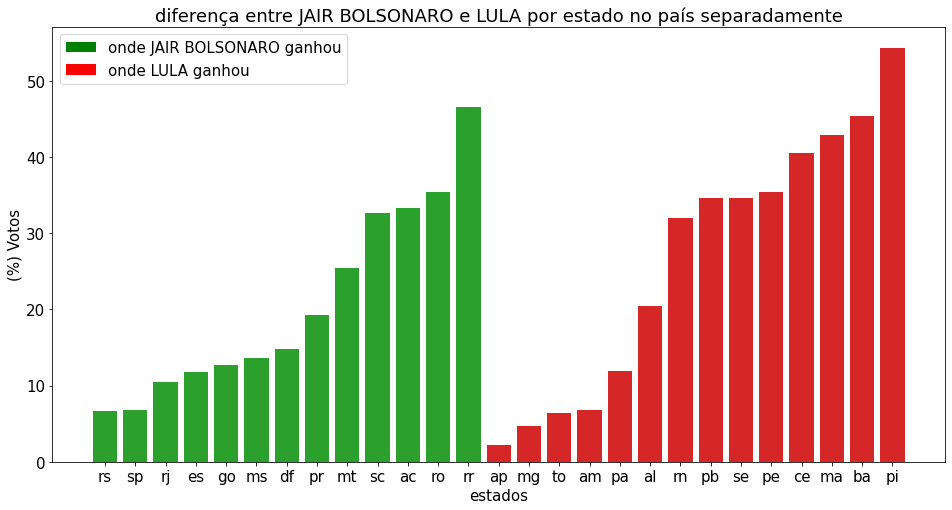

In [23]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1)

Aqui podemos perceber que a expressividade proporcional do gráfico anterior engana

>Piauí (PI), mesmo sendo o que tem mais "lulistas" proporcionalmente, não foi o que conseguiu mais votos para lula, e sim a Bahia, que teve o segundo lugar nesse quesito

>São Paulo (SP) torna essa diferença ainda mais nitida, proporcionalmente ele é o segundo **menos** bolsonarista, mas é o que conseguiu mais voto para o candidato

<function matplotlib.pyplot.show(*args, **kw)>

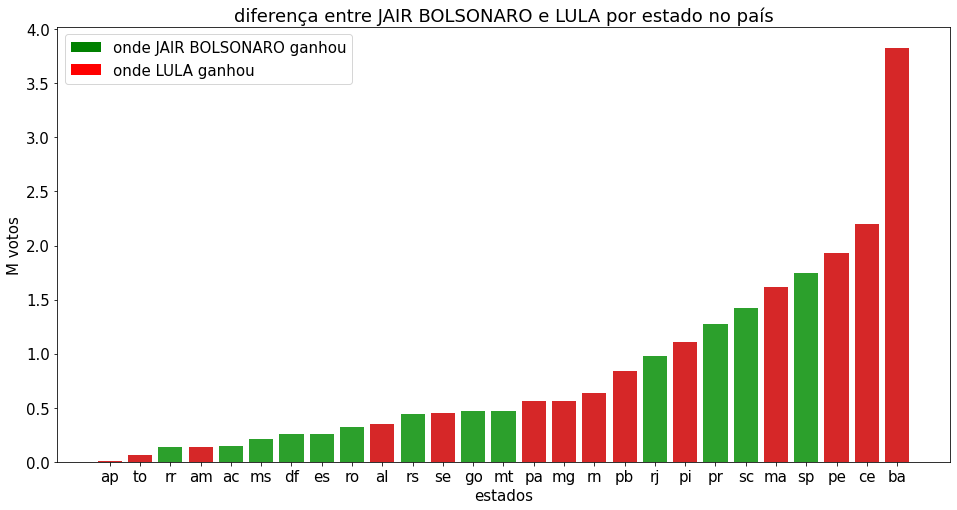

In [24]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='Votos',mode = 0)

visto que uma população suficientemente grande pode ultrapassar uma menor em numeros de votos, mesmo tendo poucos pontos percentuais contra uma grande vantagem, percebe-se que basta uma nação grande e decidida o suficiente para ofuscar grande parte dos estados menores e praticamente decidir a eleição

> entretanto, parece que algo impede isso como visto no grafico abaixo

<function matplotlib.pyplot.show(*args, **kw)>

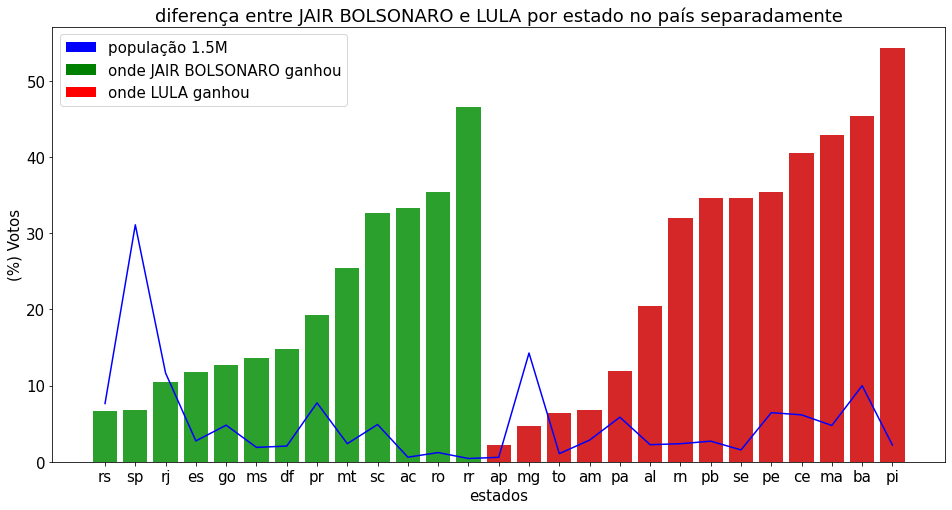

In [25]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[populacao])

>O grafico acima nos mostra que quanto maior é a população, maior a tendencia dela a um extremo

>Isso se assemelha a situação dos mercados de ações em que quanto menor o volume/valor de mercado maior é a volatilidade do ativo

>Aparentemente um maior número de pessoas/agentes funciona como um freio, onde quanto mais pessoas, mais difícil é de ordenar-las em uma mesma direção

Agora o segundo problema é, porque que esses respectivos estados preferem o Bolsonaro enquanto os outros o Lula, Será que há um dado numérico, que possa caracterizar o porque de um ser lulista e o outro não?

Abaixo a comparação entre estados através do Pib (2019) e do pib per capta parcial ( Pib de 2019 / população de 2021 )

<function matplotlib.pyplot.show(*args, **kw)>

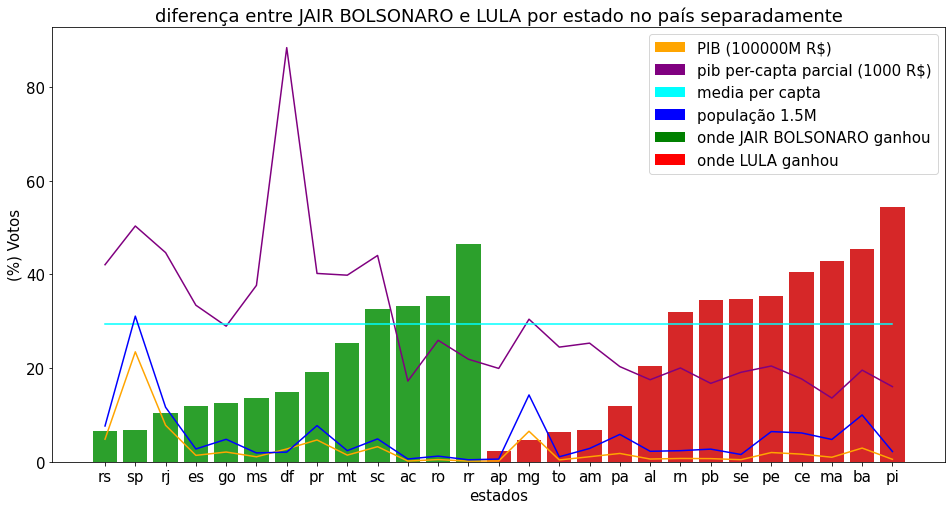

In [26]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[pib,pibPerCapta, media, populacao])

> ordenando por pib para melhor visualização

<function matplotlib.pyplot.show(*args, **kw)>

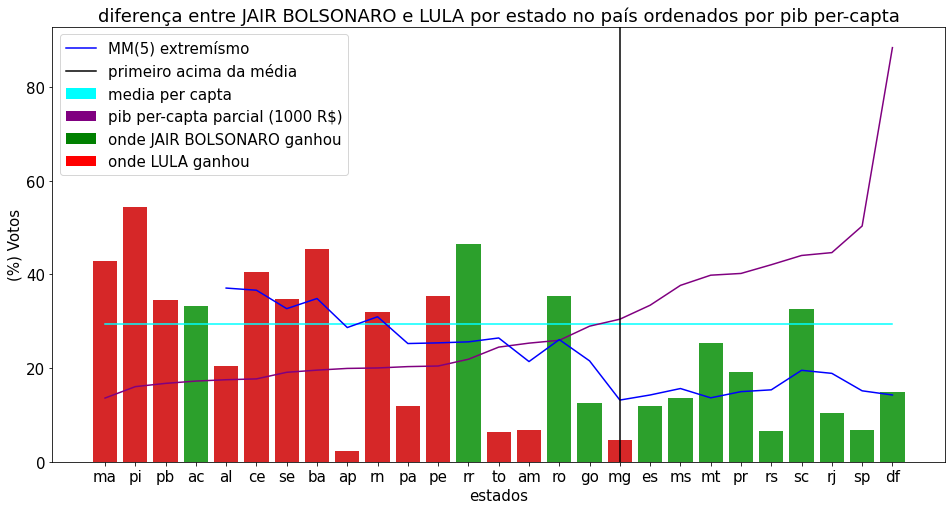

In [27]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 3, 
                 aditionalFuncs=[
                     media,pibPerCapta,extremizeMedia,
                     verticalLine('mg','primeiro acima da média')
                    ], ordenator='pib per-capta')

Aparentemente não há uma simples relação direta entre o quão bolsonarista/lulista um estado é de acordo com o seu respectivo Pib per capta, porém duas coisas podem ser constatadas

> 1 - Quanto menor o pib per capta, maior é a **probabilidade** de preferencia ao Lula, visto que dos 17 estados abaixo da média, ele venceu em 13, o mesmo para Bolsonaro, que venceu em 9 entre os 10 que estavam acima da média brasileira

> 2 - Assim como a população, quanto menor o pib per capta maior é a tendencia ao extremismo, visto que os 10 estados mais extremistas estão com o seu pib abaixo da média brasileira

abaixo o gráfico das diferenças ordenadospelo extremismo


<function matplotlib.pyplot.show(*args, **kw)>

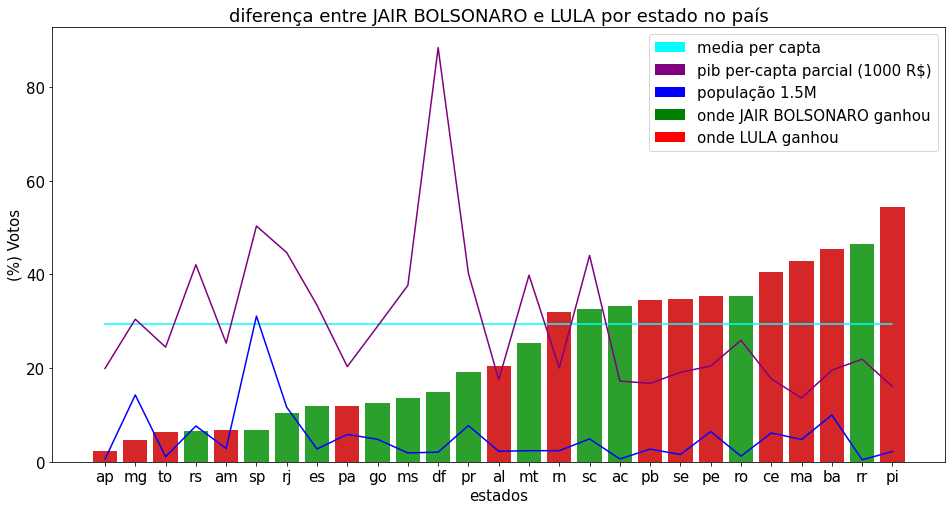

In [28]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 0,aditionalFuncs=[media,pibPerCapta, populacao, ])

Nos dados representados anteriormente RR e PI tem se demontrado muitos semelhantes, exceto pela diferença entre o candidato que escolheram

## 5.2 Piauí e Roraima, os estados mais extremistas

A partir de agora o objetivo da análise é descobrir o porque dessa diferença e o que pode estar relacionado com essa escolha

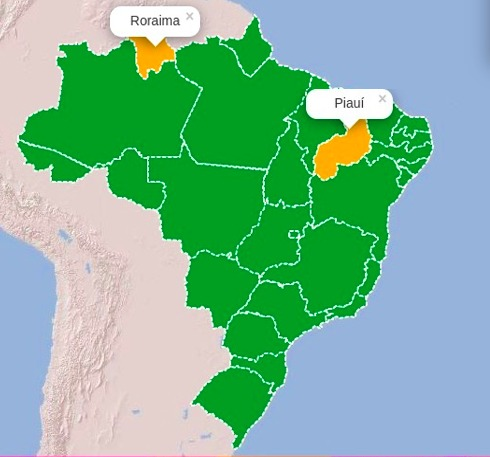